In [2]:
import pandas as pd

In [3]:
import mysql.connector
from mysql.connector import Error

import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="waleedahmed",
  database="us_boxing"
)

In [4]:
cur = mydb.cursor()
sales_query = "SELECT oi.item_updated_at,oi.item_sku,p.parent_sku_id,oi.order_id AS `Order Item Order Id`,oi.sub_total,oi.item_status,o.channel_id,o.customer_type,c.name FROM order_items oi INNER JOIN orders o ON oi.order_id=o.id INNER JOIN channels c ON c.id = o.channel_id INNER JOIN products p ON oi.item_sku=p.sku"
cur.execute(sales_query)
df_sales= pd.DataFrame(data=cur.fetchall(),columns=['updated_at','sku','parent_sku','order_id','sub_total','item_status','channel_id','customer_type','channel_name'])
df_sales.head()

,updated_at,sku,parent_sku,order_id,sub_total,item_status,channel_id,customer_type,channel_name
0,2019-10-09 09:18:40,ADIH200BLKGLD14oz,5057.0,1,49.00,canceled,16,B2C,usboxing.net
1,2019-12-23 07:37:08,ADIBP10NTransparentSenior,5180.0,2,3.00,canceled,16,B2C,usboxing.net
2,2019-10-04 23:14:55,ADISBG501Black/Gold16OZ,5054.0,3,149.95,shipped,16,B2C,usboxing.net
3,2019-10-04 05:15:23,AIBAH1RedM,5130.0,4,119.95,shipped,16,B2C,usboxing.net
4,2019-09-30 22:05:26,ADIH500PROBlack/Gold/Silver14OZ,6491.0,5,169.95,shipped,16,B2C,usboxing.net


In [5]:
curr = mydb.cursor()
parents = "SELECT p.sku,p.id FROM products p WHERE p.parent_sku_id IS NULL"
curr.execute(parents)
df_parents= pd.DataFrame(data=curr.fetchall(),columns=['parent_name','parent_id'])
df_parents.head()
#SELECT p.sku,p.id FROM products p WHERE p.parent_sku_id IS NULL

,parent_name,parent_id
0,ADHBG100,4517
1,ADHTG300,4526
2,ADIBCM06,4546
3,ADIH200PL,4550
4,ADIH75,4563


In [6]:
df_sales=pd.merge(df_sales,df_parents,left_on='parent_sku',right_on='parent_id',how='inner')

In [7]:
df_sales[df_sales['parent_name']=='ADISBG50'].sku

624        ADISBG50SYLDBL14oz
625        ADISBG50SYLDBL14oz
626        ADISBG50SRDSIL14oz
627        ADISBG50SRDSIL10oz
628        ADISBG50SRDSIL10oz
                ...          
2303    ADISBG50_12oz_ORG_SIL
2304    ADISBG50_12oz_ORG_SIL
2305    ADISBG50_12oz_ORG_SIL
2306    ADISBG50_12oz_BLK_RED
2307       ADISBG50SYLDBL14oz
Name: sku, Length: 1684, dtype: object

In [8]:
df_sales.drop(df_sales[df_sales['item_status']=='canceled'].index, inplace = True)

In [9]:
df_sales['year']=df_sales['updated_at'].dt.year
df_sales['month']=df_sales['updated_at'].dt.month
df_sales['day']=df_sales['updated_at'].dt.day

In [10]:
twenty_one=df_sales.query('year==2021')

In [9]:
import seaborn as sns

conditions = [
    (twenty_one['month']>=1) & (twenty_one['month']<= 3),
    (twenty_one['month']>=4) & (twenty_one['month']<= 6),
    (twenty_one['month']>=7) & (twenty_one['month']<= 9),
    (twenty_one['month']>=10) & (twenty_one['month']<= 12)]
values = ['Q1', 'Q2', 'Q3', 'Q4']
import numpy as np
twenty_one['quarter'] = np.select(conditions, values)

<ipython-input-9-b2c01ce04a62>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_one['quarter'] = np.select(conditions, values)


In [66]:
conditions_2021_halfyearly = [
    (twenty_one['month']>=1) & (twenty_one['month'] <= 6),
    (twenty_one['month'] >=7) & (twenty_one['month'] <= 12)]
values_2021_half_yearly = ['1st_half', '2nd_half']
twenty_one['half_yearly'] = np.select(conditions_2021_halfyearly, values_2021_half_yearly)

<ipython-input-66-1d7e8039e965>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_one['half_yearly'] = np.select(conditions_2021_halfyearly, values_2021_half_yearly)


In [67]:
half_yearly_2021=twenty_one.groupby(['parent_name','half_yearly','channel_name'])['order_id'].count()
half_yearly_2021=pd.DataFrame(half_yearly_2021)
half_yearly_2021.reset_index(inplace=True)
half_yearly_2021.columns=['parent_name','half_yearly','channel_name','order_count']

In [68]:
half_yearly_2021

,parent_name,half_yearly,channel_name,order_count
0,ADIACC044CS,1st_half,usboxingamazon,1
1,ADIBAC0112,1st_half,usfightstore,1
2,ADIBAC091,1st_half,usboxing.net,1
3,ADIBAC091,1st_half,usboxingamazon,1
4,ADIBHGF01,1st_half,usboxing.net,10
...,...,...,...,...
139,HYPVOR2,1st_half,usfightstore,4
140,adiCL02B,1st_half,usboxing.net,3
141,adiWBCT01,1st_half,usboxing.net,2
142,adiWBCTB01,1st_half,usboxing.net,2


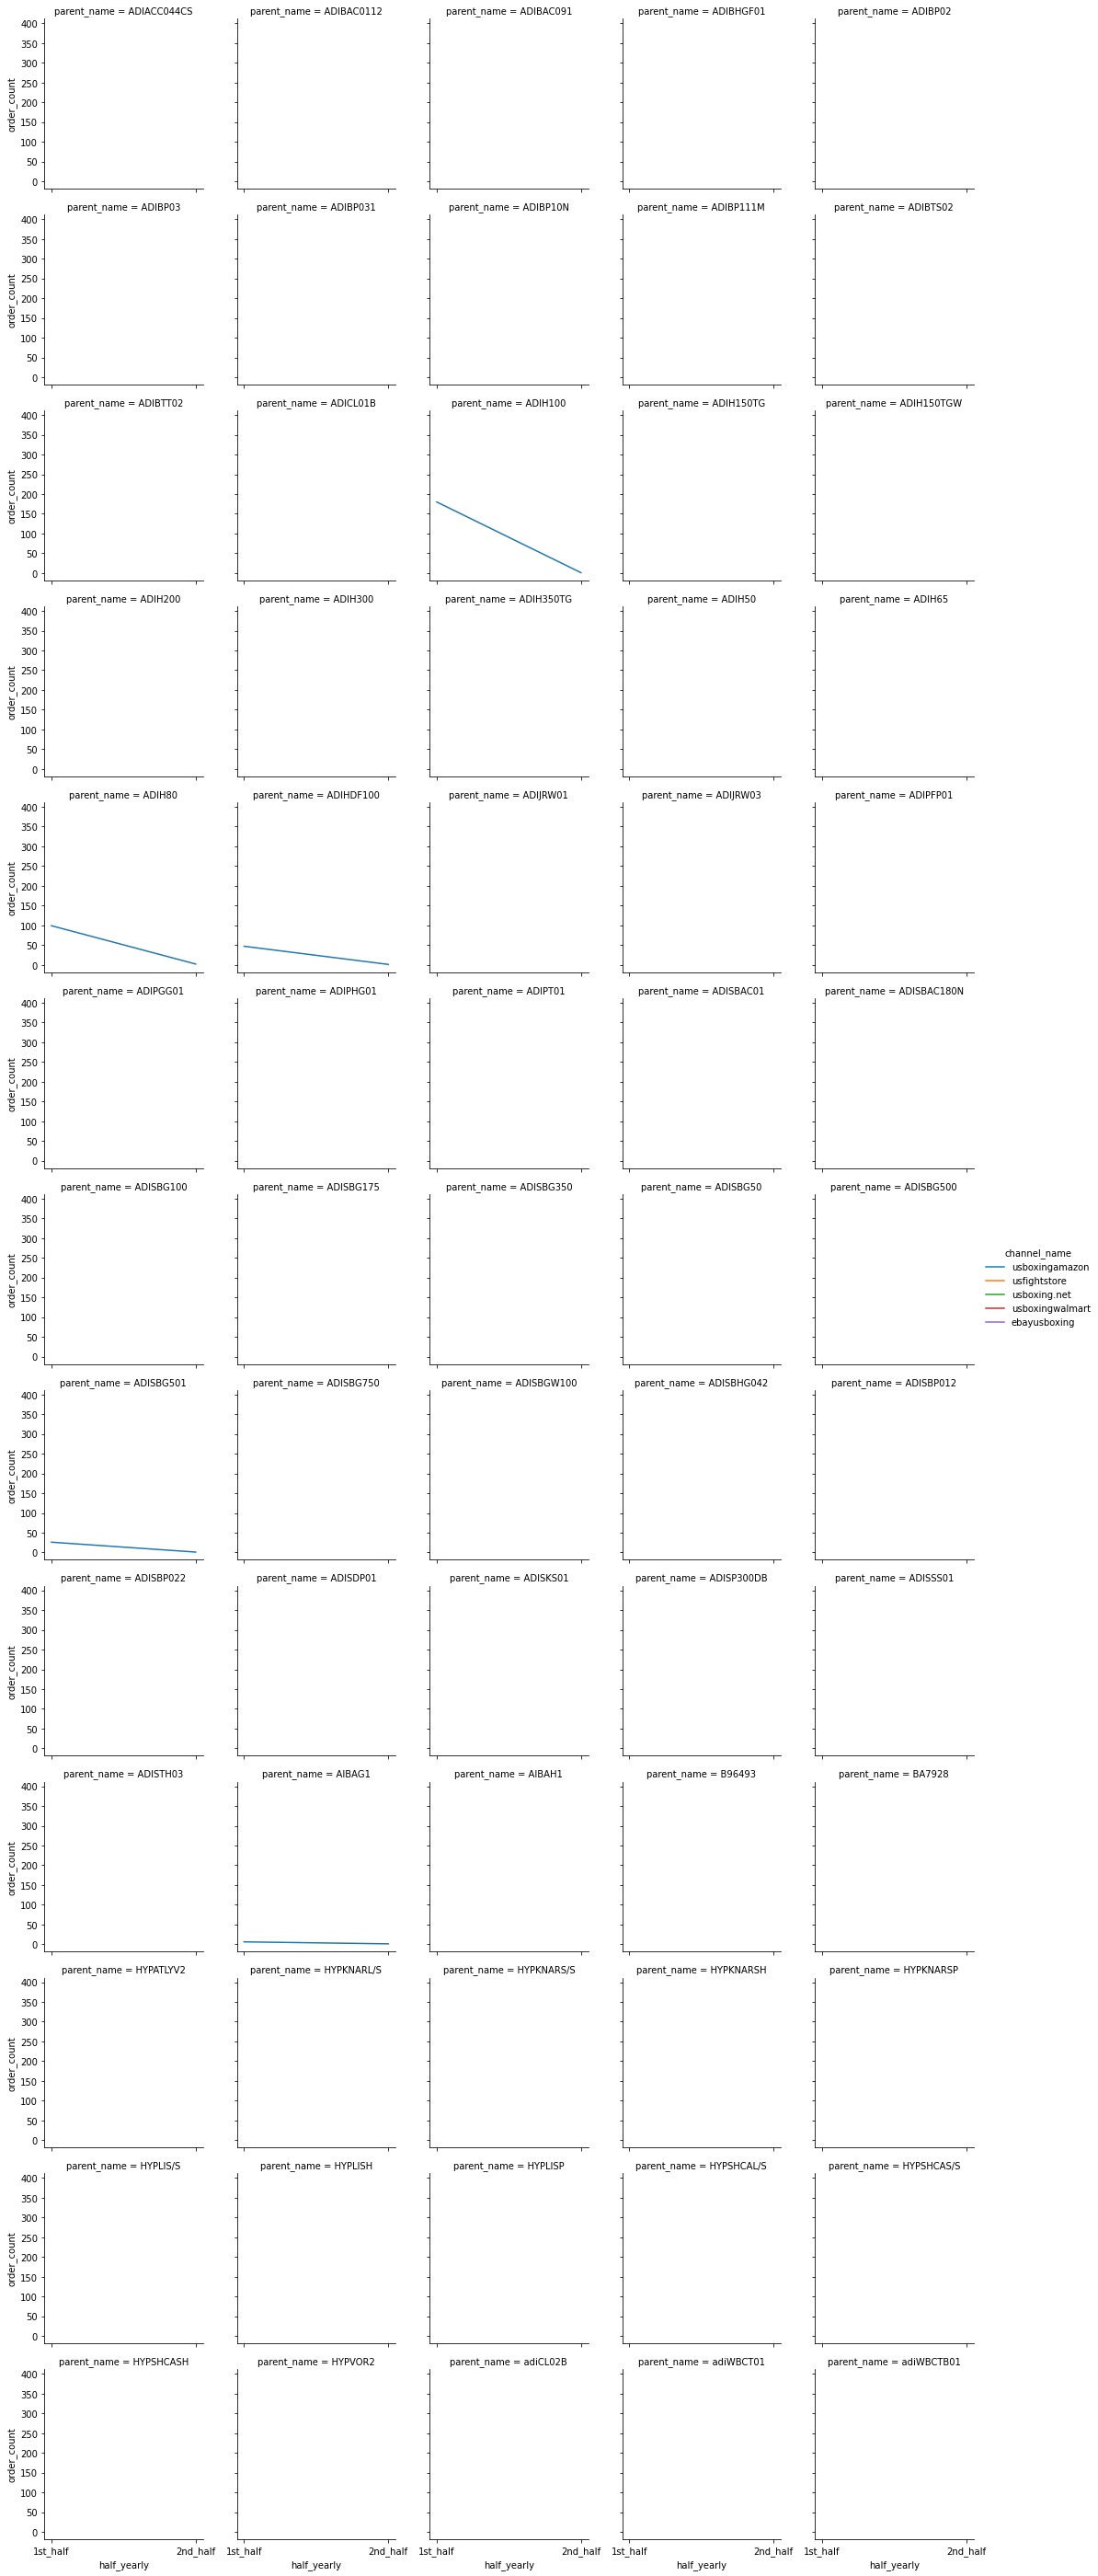

In [69]:
c=sns.FacetGrid(half_yearly_2021, col='parent_name',hue='channel_name',col_wrap=5)
c=c.map(sns.lineplot,'half_yearly', 'order_count').add_legend()

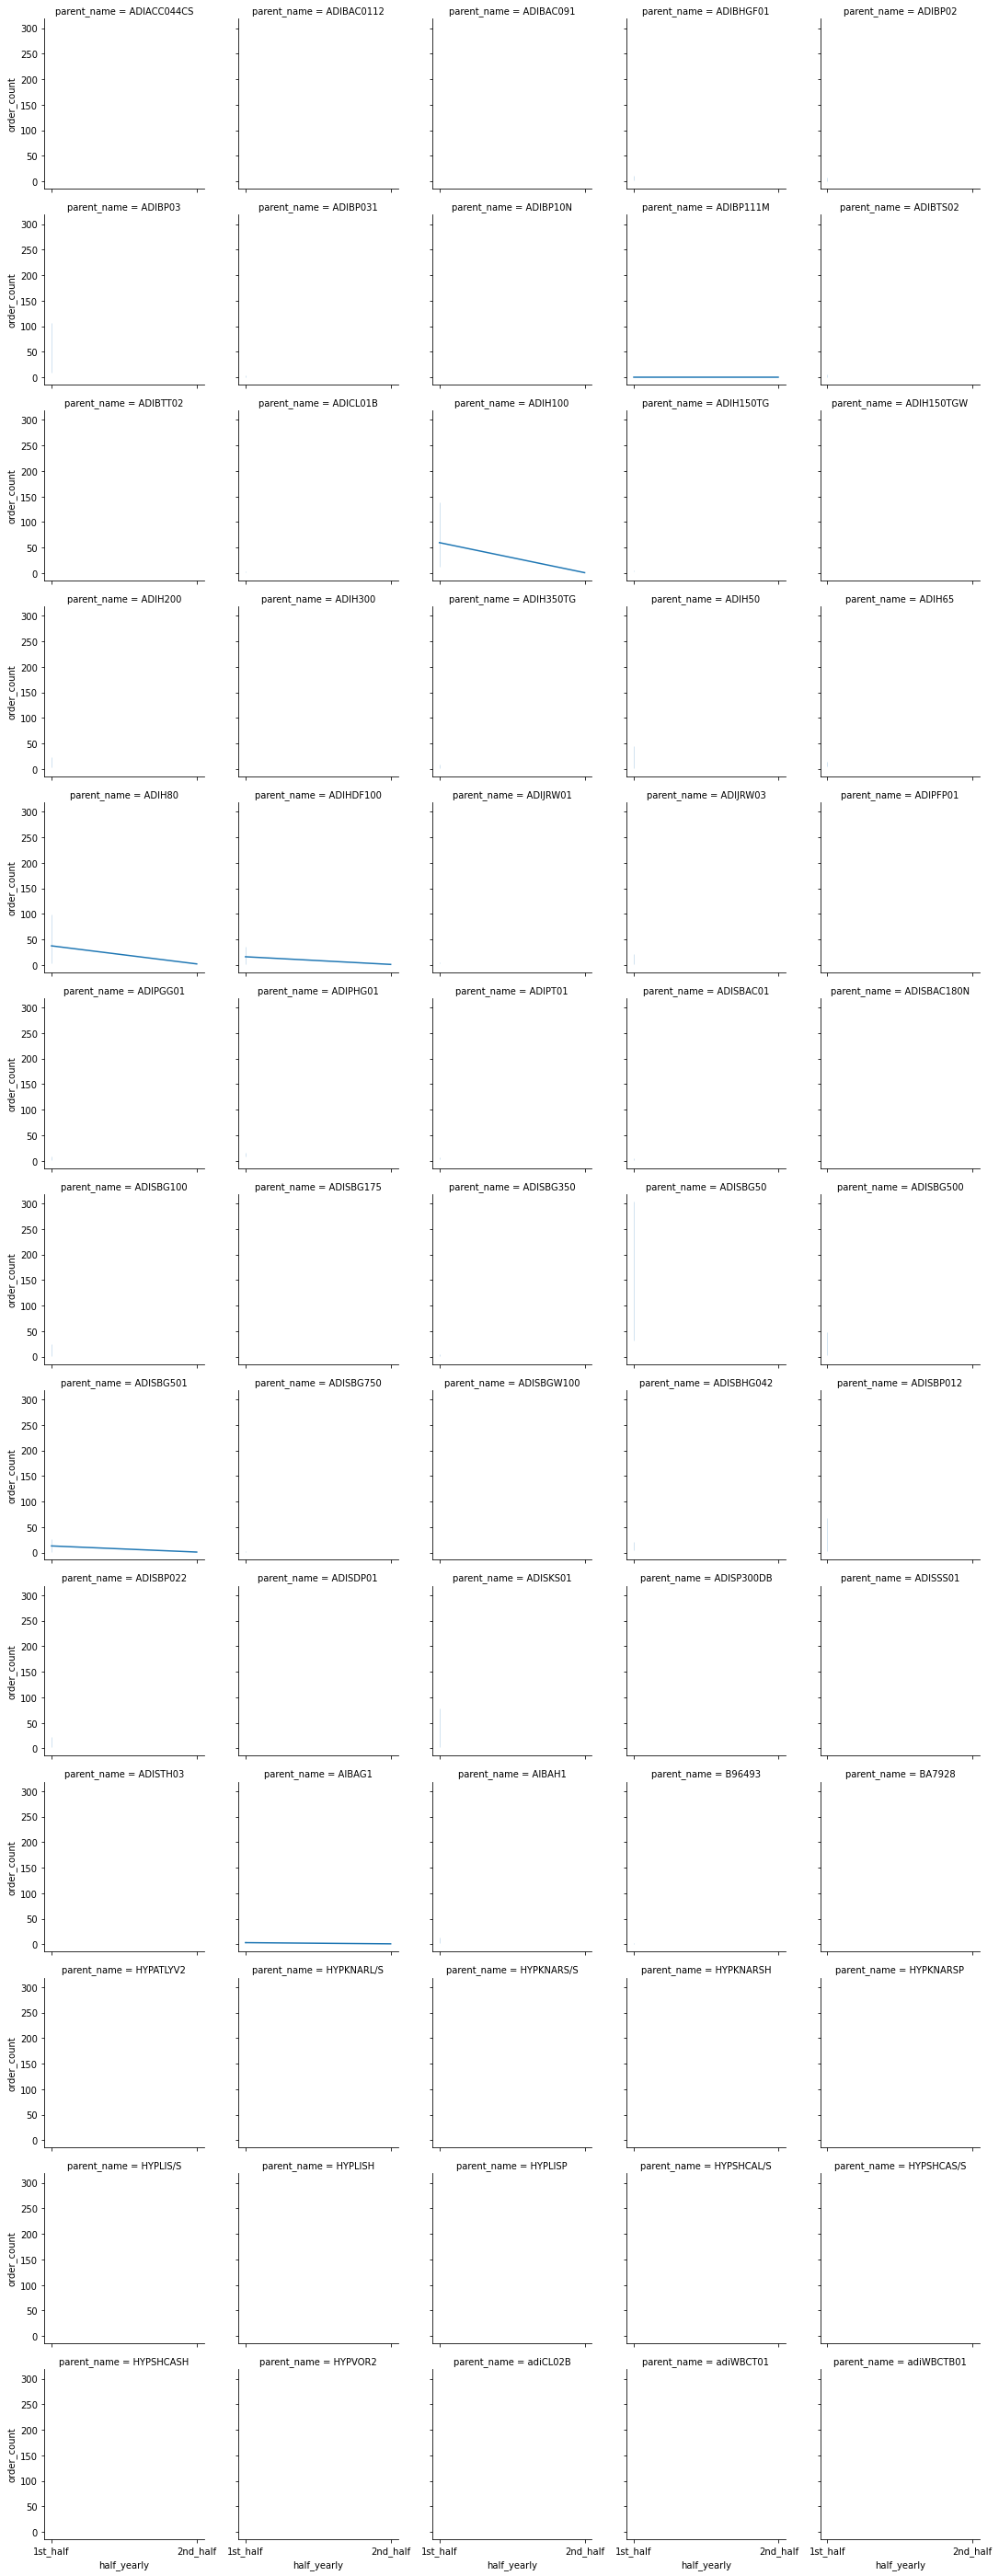

In [70]:
e=sns.FacetGrid(half_yearly_2021, col='parent_name',col_wrap=5)
e=e.map(sns.lineplot,'half_yearly', 'order_count').add_legend()

In [71]:
quarterly_2021=twenty_one.groupby(['parent_name','quarter','channel_name'])['order_id'].count()
quarterly_2021=pd.DataFrame(quarterly_2021)
quarterly_2021
quarterly_2021.columns=['order_count']

In [72]:
quarterly_2021.reset_index(inplace=True)

In [73]:
quarterly_2021

,parent_name,quarter,channel_name,order_count
0,ADIACC044CS,Q2,usboxingamazon,1
1,ADIBAC0112,Q2,usfightstore,1
2,ADIBAC091,Q2,usboxing.net,1
3,ADIBAC091,Q2,usboxingamazon,1
4,ADIBHGF01,Q1,usboxing.net,4
...,...,...,...,...
194,HYPVOR2,Q2,usfightstore,1
195,adiCL02B,Q2,usboxing.net,3
196,adiWBCT01,Q2,usboxing.net,2
197,adiWBCTB01,Q2,usboxing.net,2


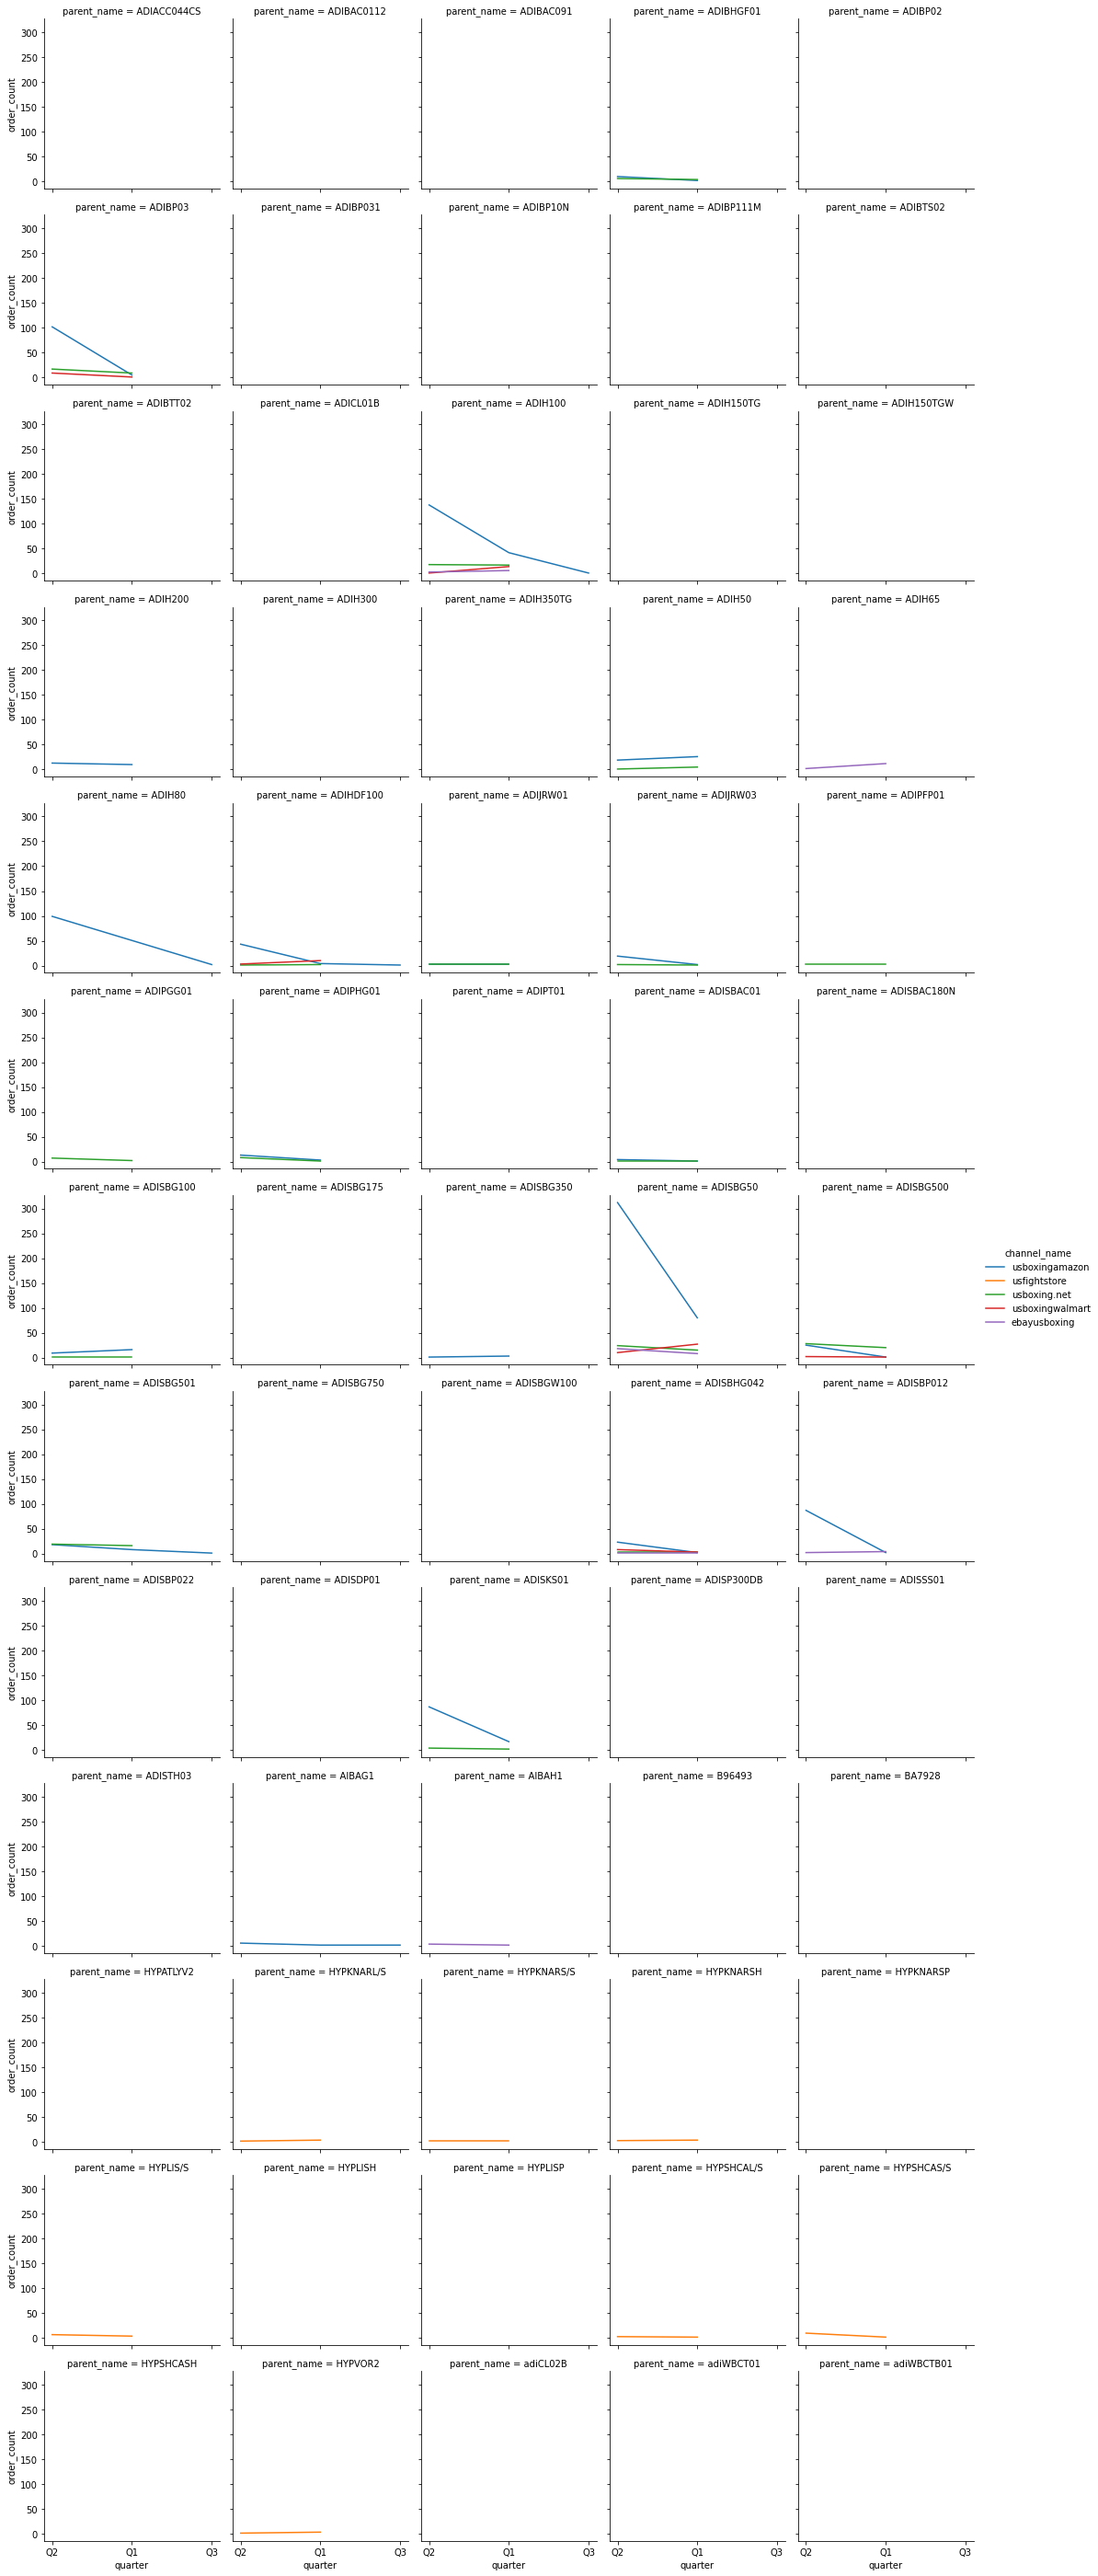

In [74]:
s=sns.FacetGrid(quarterly_2021, col='parent_name',hue='channel_name',col_wrap=5)
s=s.map(sns.lineplot,'quarter', 'order_count').add_legend()

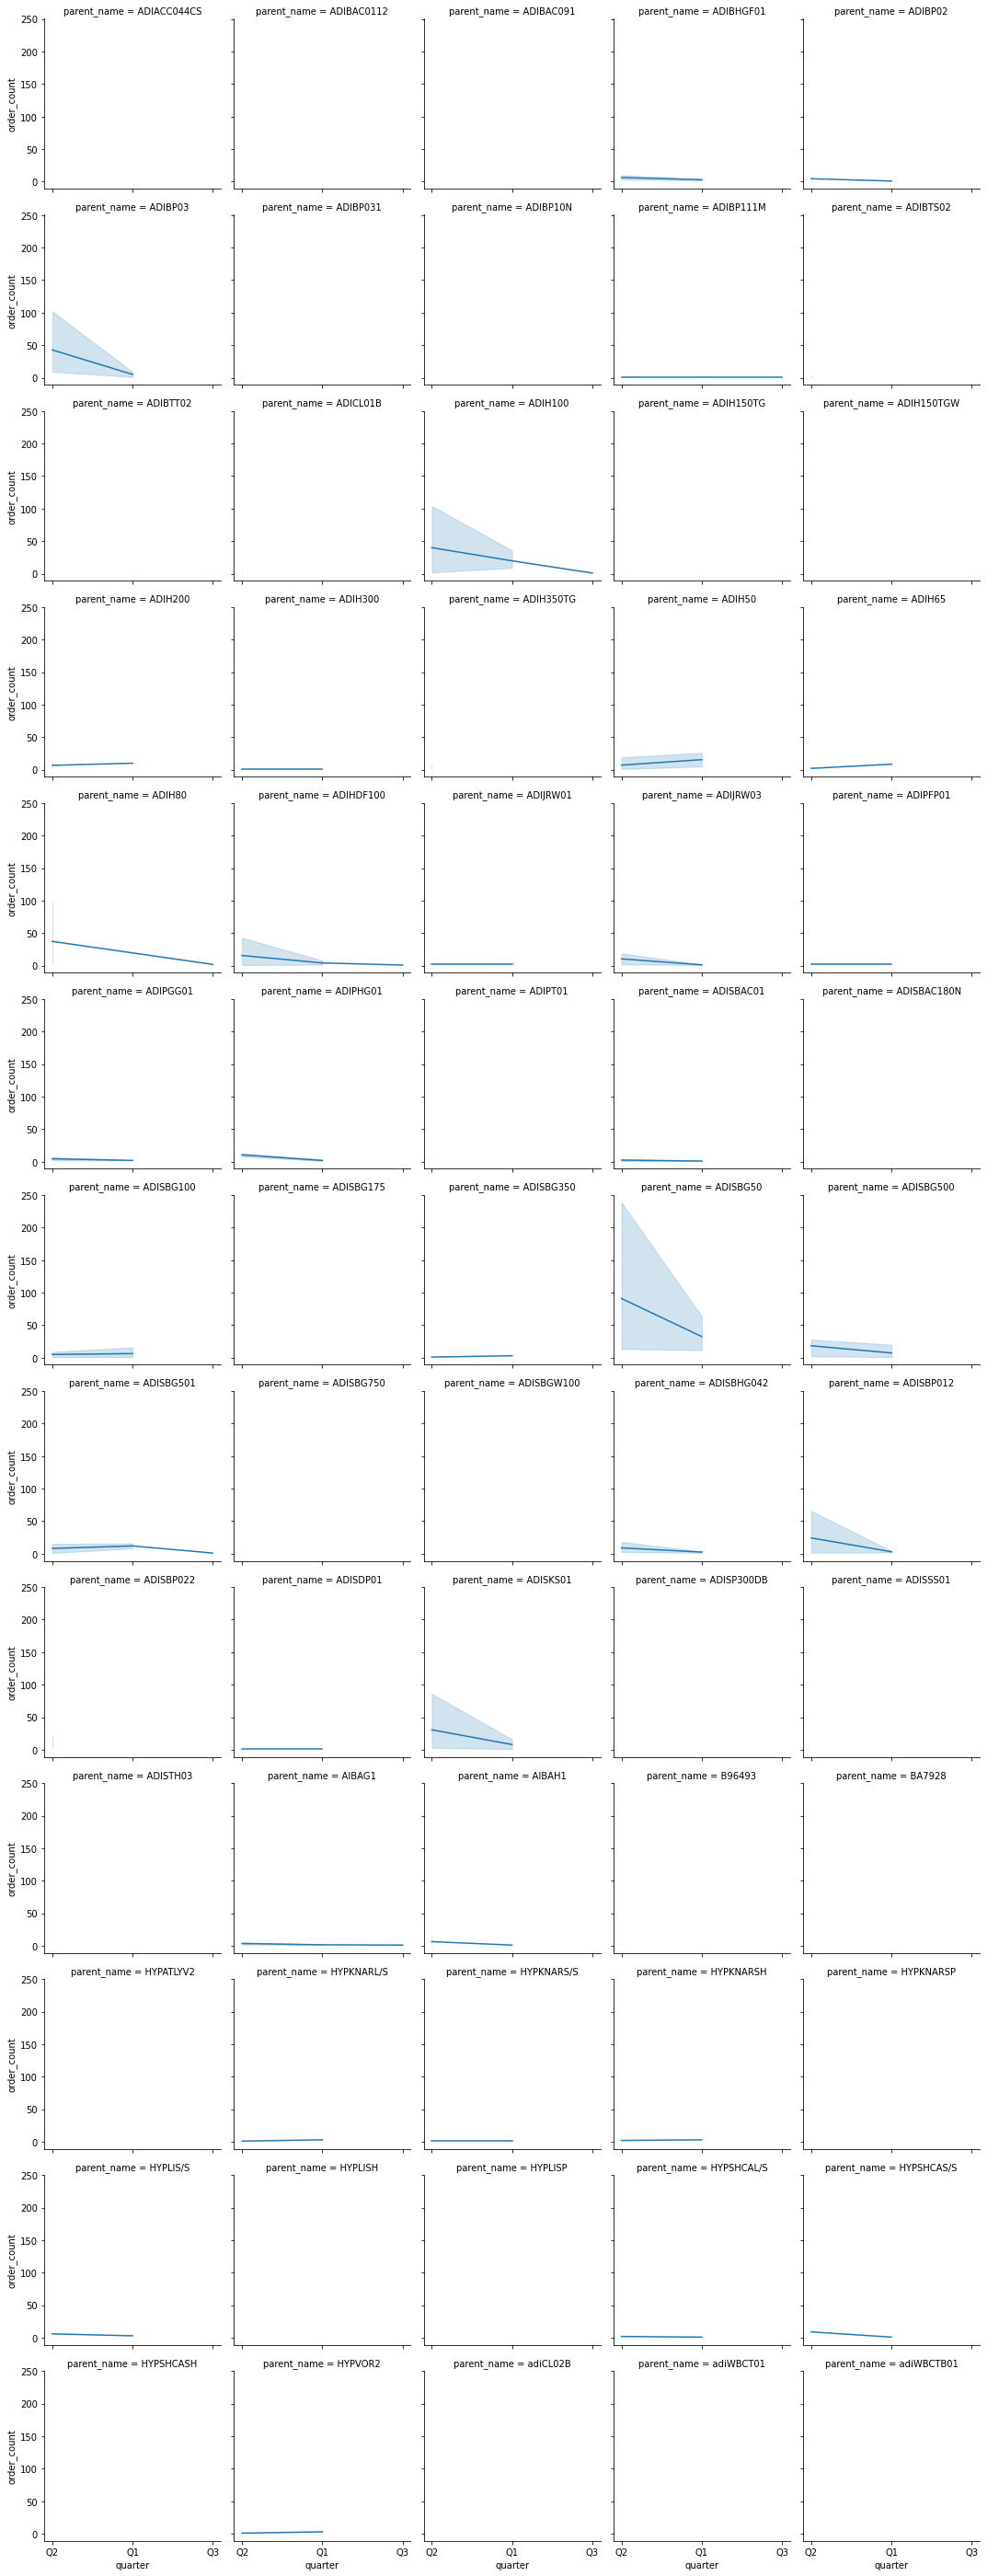

In [75]:
t=sns.FacetGrid(quarterly_2021, col='parent_name',col_wrap=5)
t=t.map(sns.lineplot,'quarter', 'order_count').add_legend()

In [76]:
monthly_2021=twenty_one.groupby(['parent_name','month','channel_name'])['order_id'].count()
monthly_2021=pd.DataFrame(monthly_2021)
monthly_2021.columns=['order_count']

In [77]:
monthly_2021.reset_index(inplace=True)

In [78]:
monthly_2021

,parent_name,month,channel_name,order_count
0,ADIACC044CS,6,usboxingamazon,1
1,ADIBAC0112,6,usfightstore,1
2,ADIBAC091,4,usboxingamazon,1
3,ADIBAC091,6,usboxing.net,1
4,ADIBHGF01,2,usboxing.net,4
...,...,...,...,...
327,adiCL02B,6,usboxing.net,3
328,adiWBCT01,6,usboxing.net,2
329,adiWBCTB01,5,usboxing.net,1
330,adiWBCTB01,6,usboxing.net,1


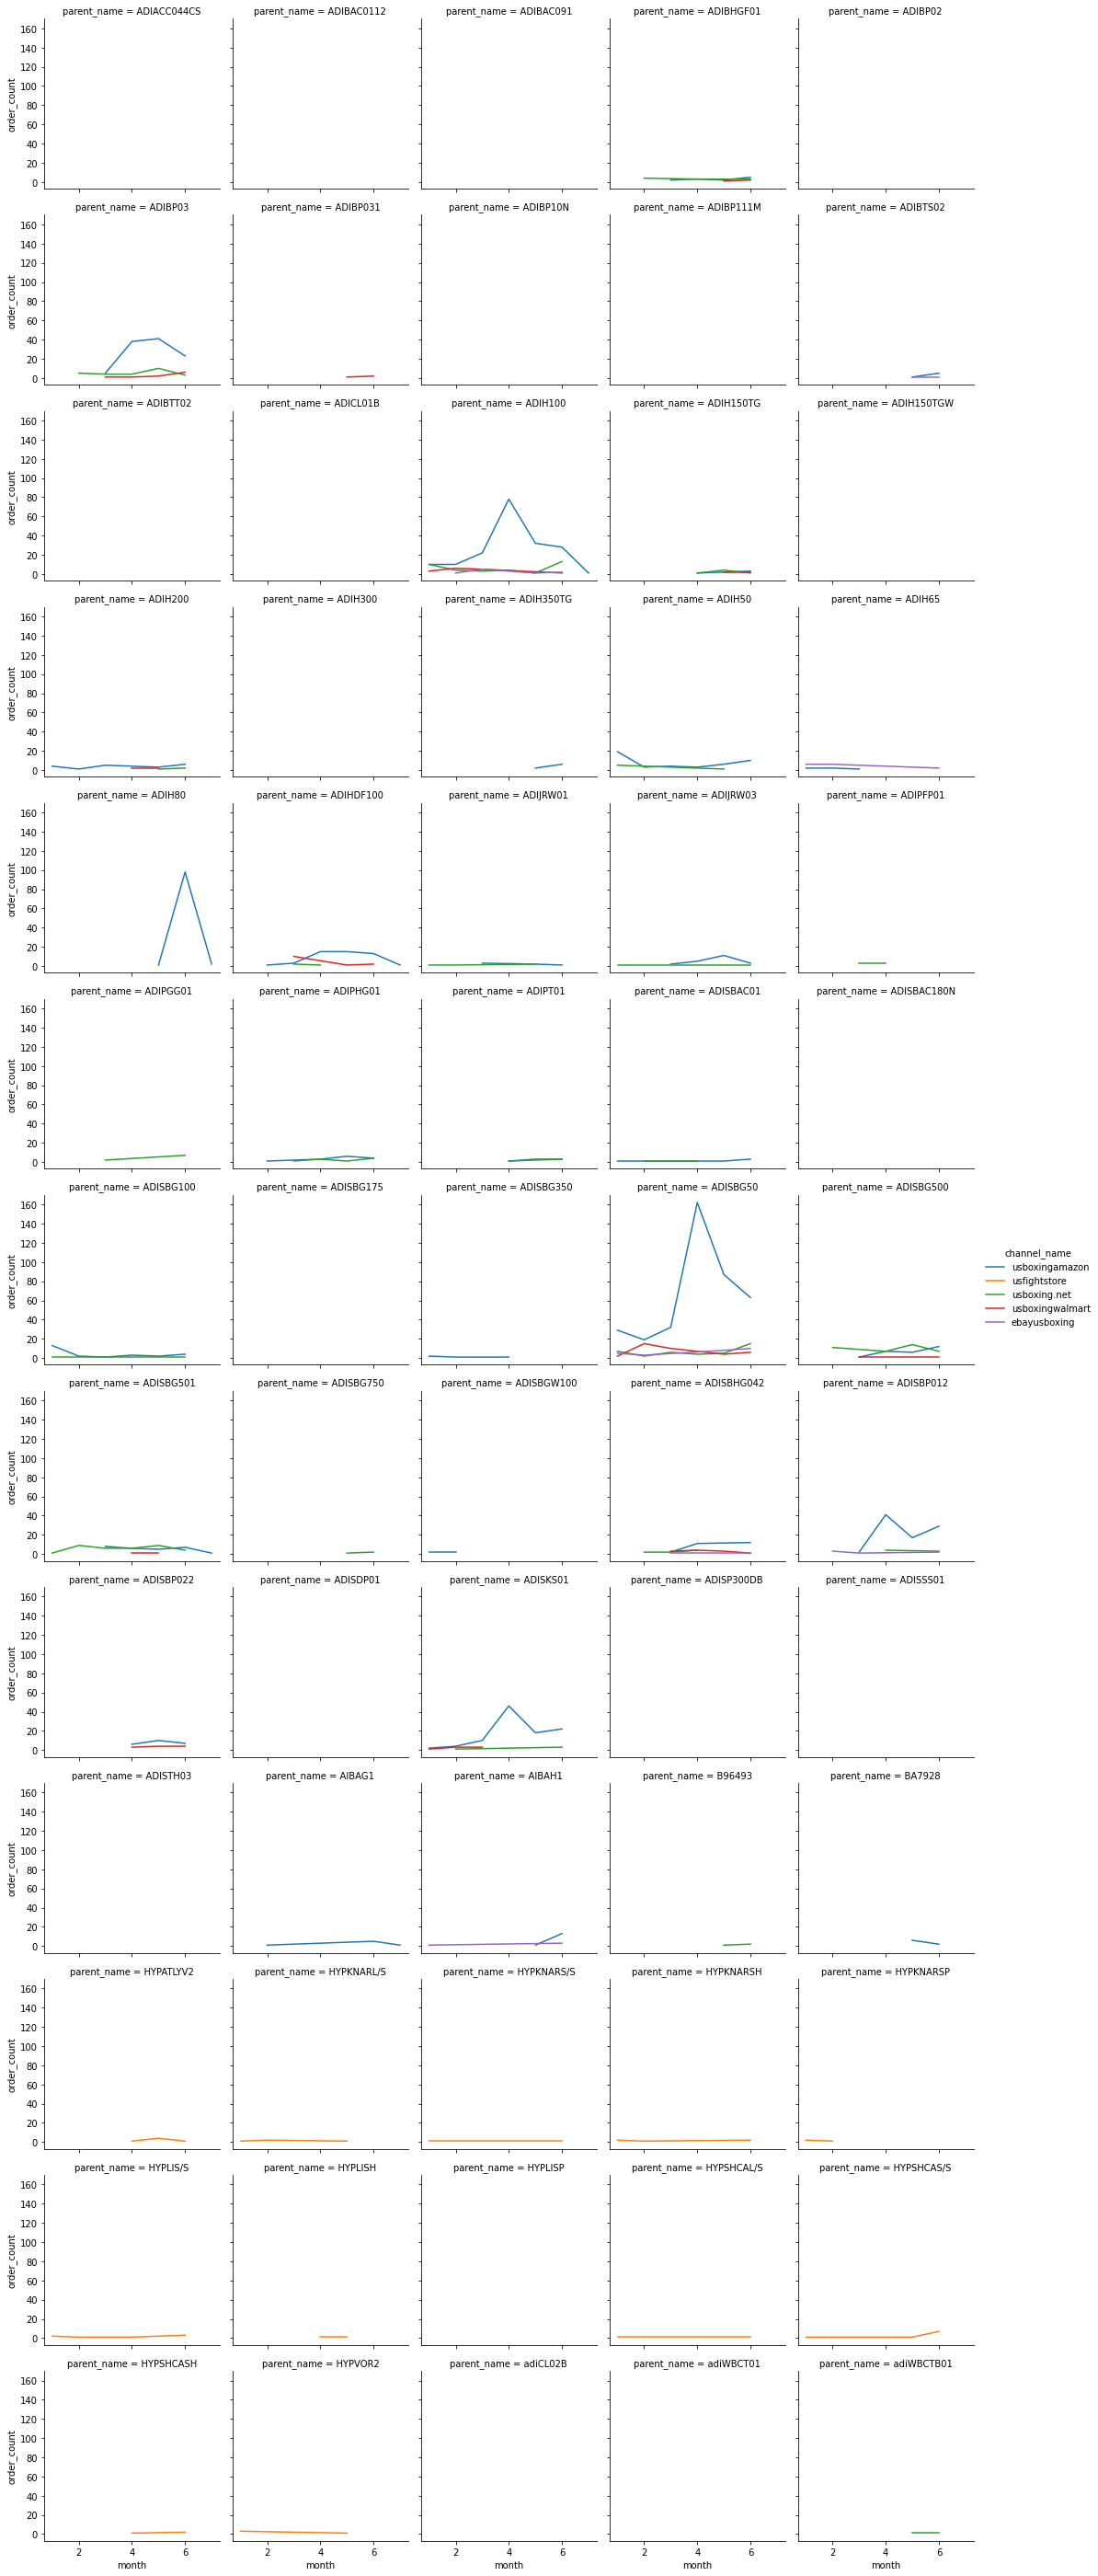

In [79]:
l=sns.FacetGrid(monthly_2021, col='parent_name',hue='channel_name',col_wrap=5)
l=l.map(sns.lineplot,'month', 'order_count').add_legend()

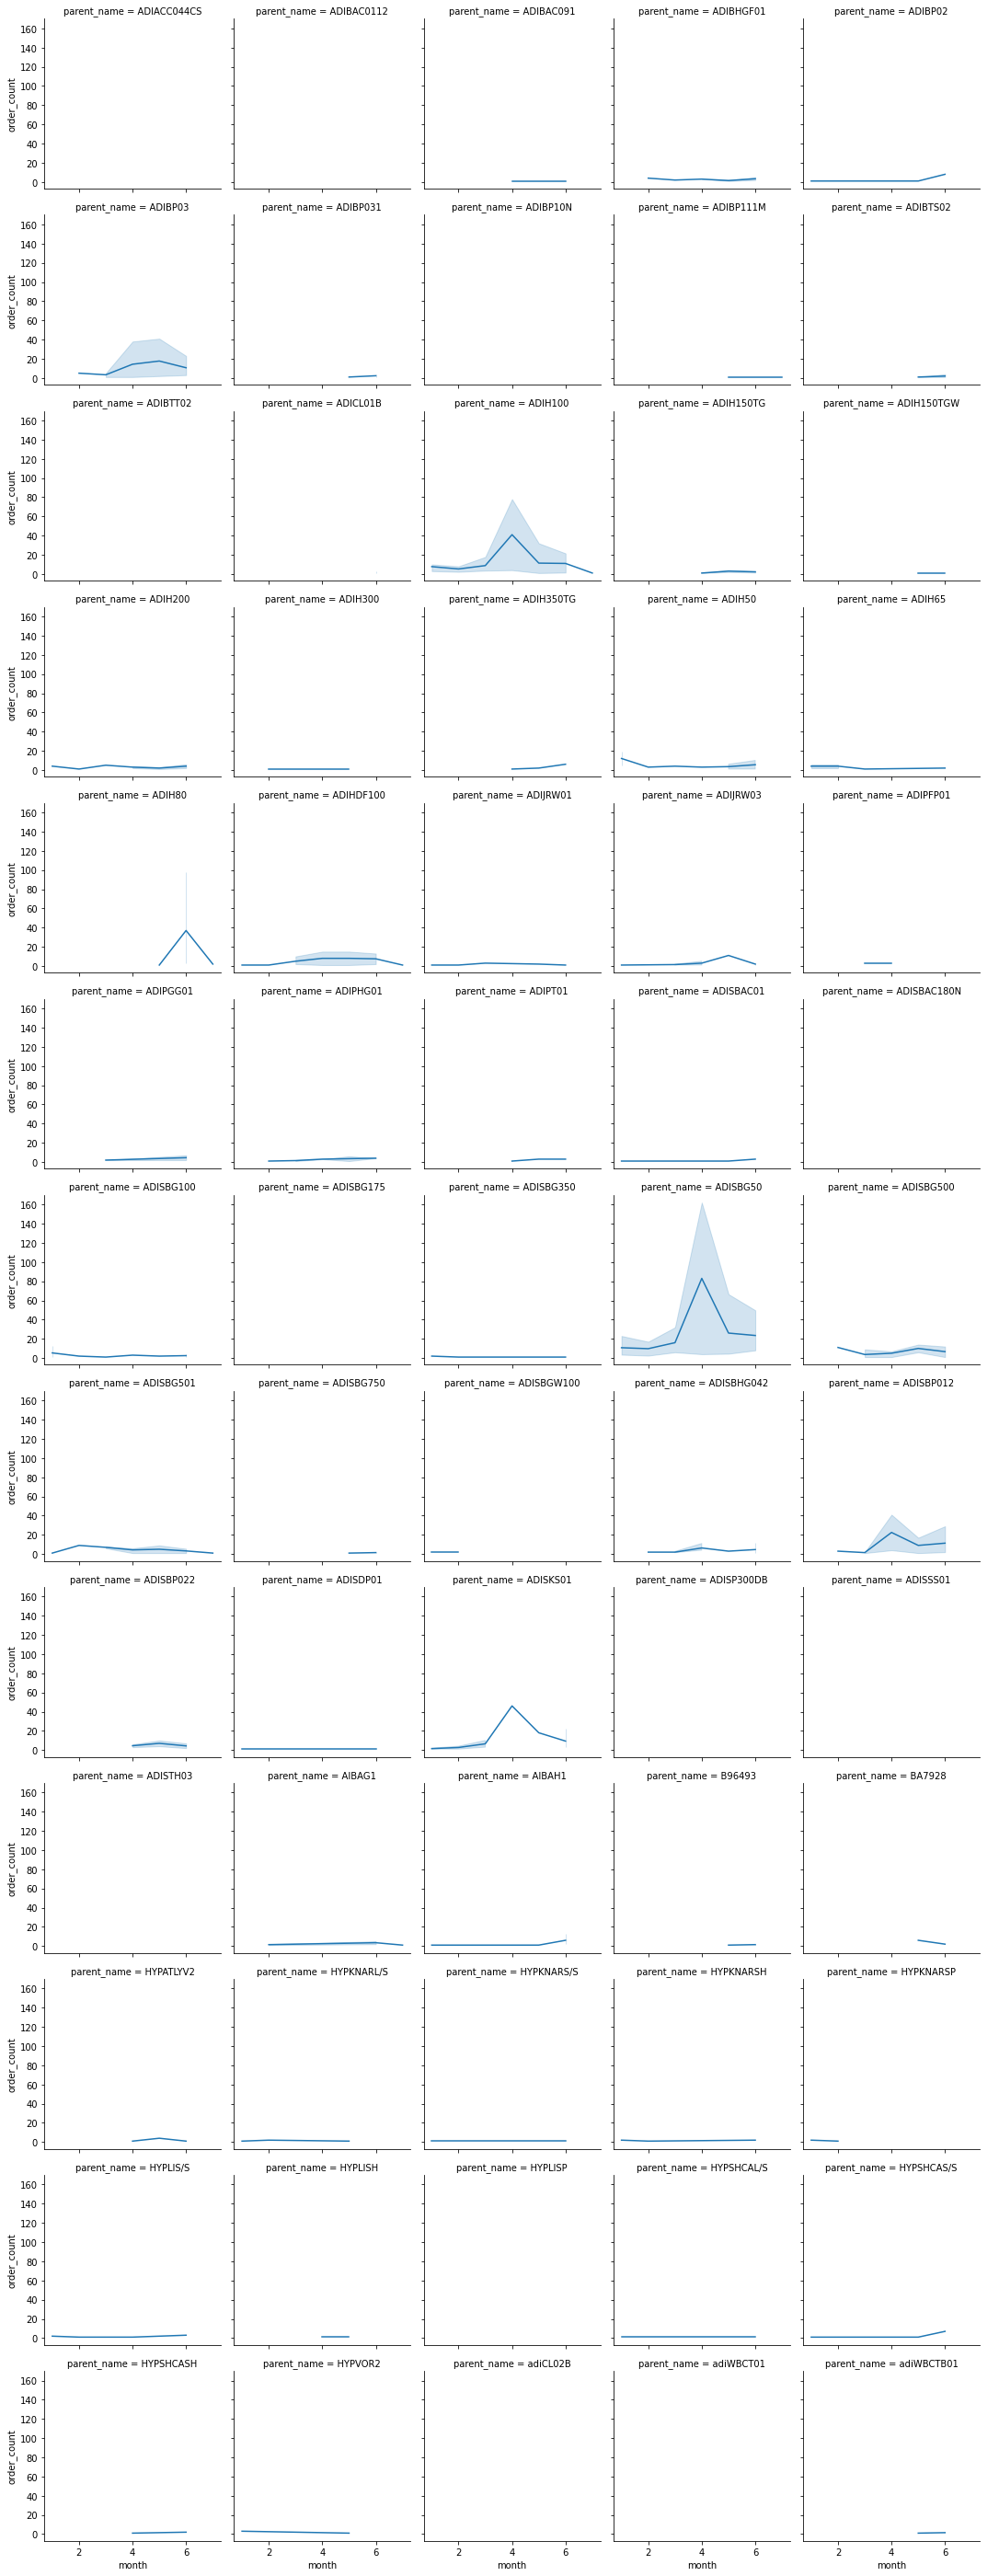

In [80]:
l=sns.FacetGrid(monthly_2021, col='parent_name',col_wrap=5)
l=l.map(sns.lineplot,'month', 'order_count').add_legend()

In [81]:
sales_21_quarterly=twenty_one.groupby(['parent_name','quarter','channel_name'])['sub_total'].sum()
sales_21_quarterly=pd.DataFrame(sales_21_quarterly)

In [82]:
sales_21_quarterly.reset_index(inplace=True)

In [83]:
sales_21_quarterly.columns=['parent_name','quarter','channel_name','sub_total']


In [100]:
sales_21_quarterly[sales_21_quarterly['parent_name']=='ADISBG50']

,parent_name,quarter,channel_name,sub_total
110,ADISBG50,Q1,ebayusboxing,359.40
111,ADISBG50,Q1,usboxing.net,907.50
112,ADISBG50,Q1,usboxingamazon,2566.47
113,ADISBG50,Q1,usboxingwalmart,838.60
114,ADISBG50,Q2,ebayusboxing,629.10
115,ADISBG50,Q2,usboxing.net,1814.13
116,ADISBG50,Q2,usboxingamazon,9942.59
117,ADISBG50,Q2,usboxingwalmart,329.50


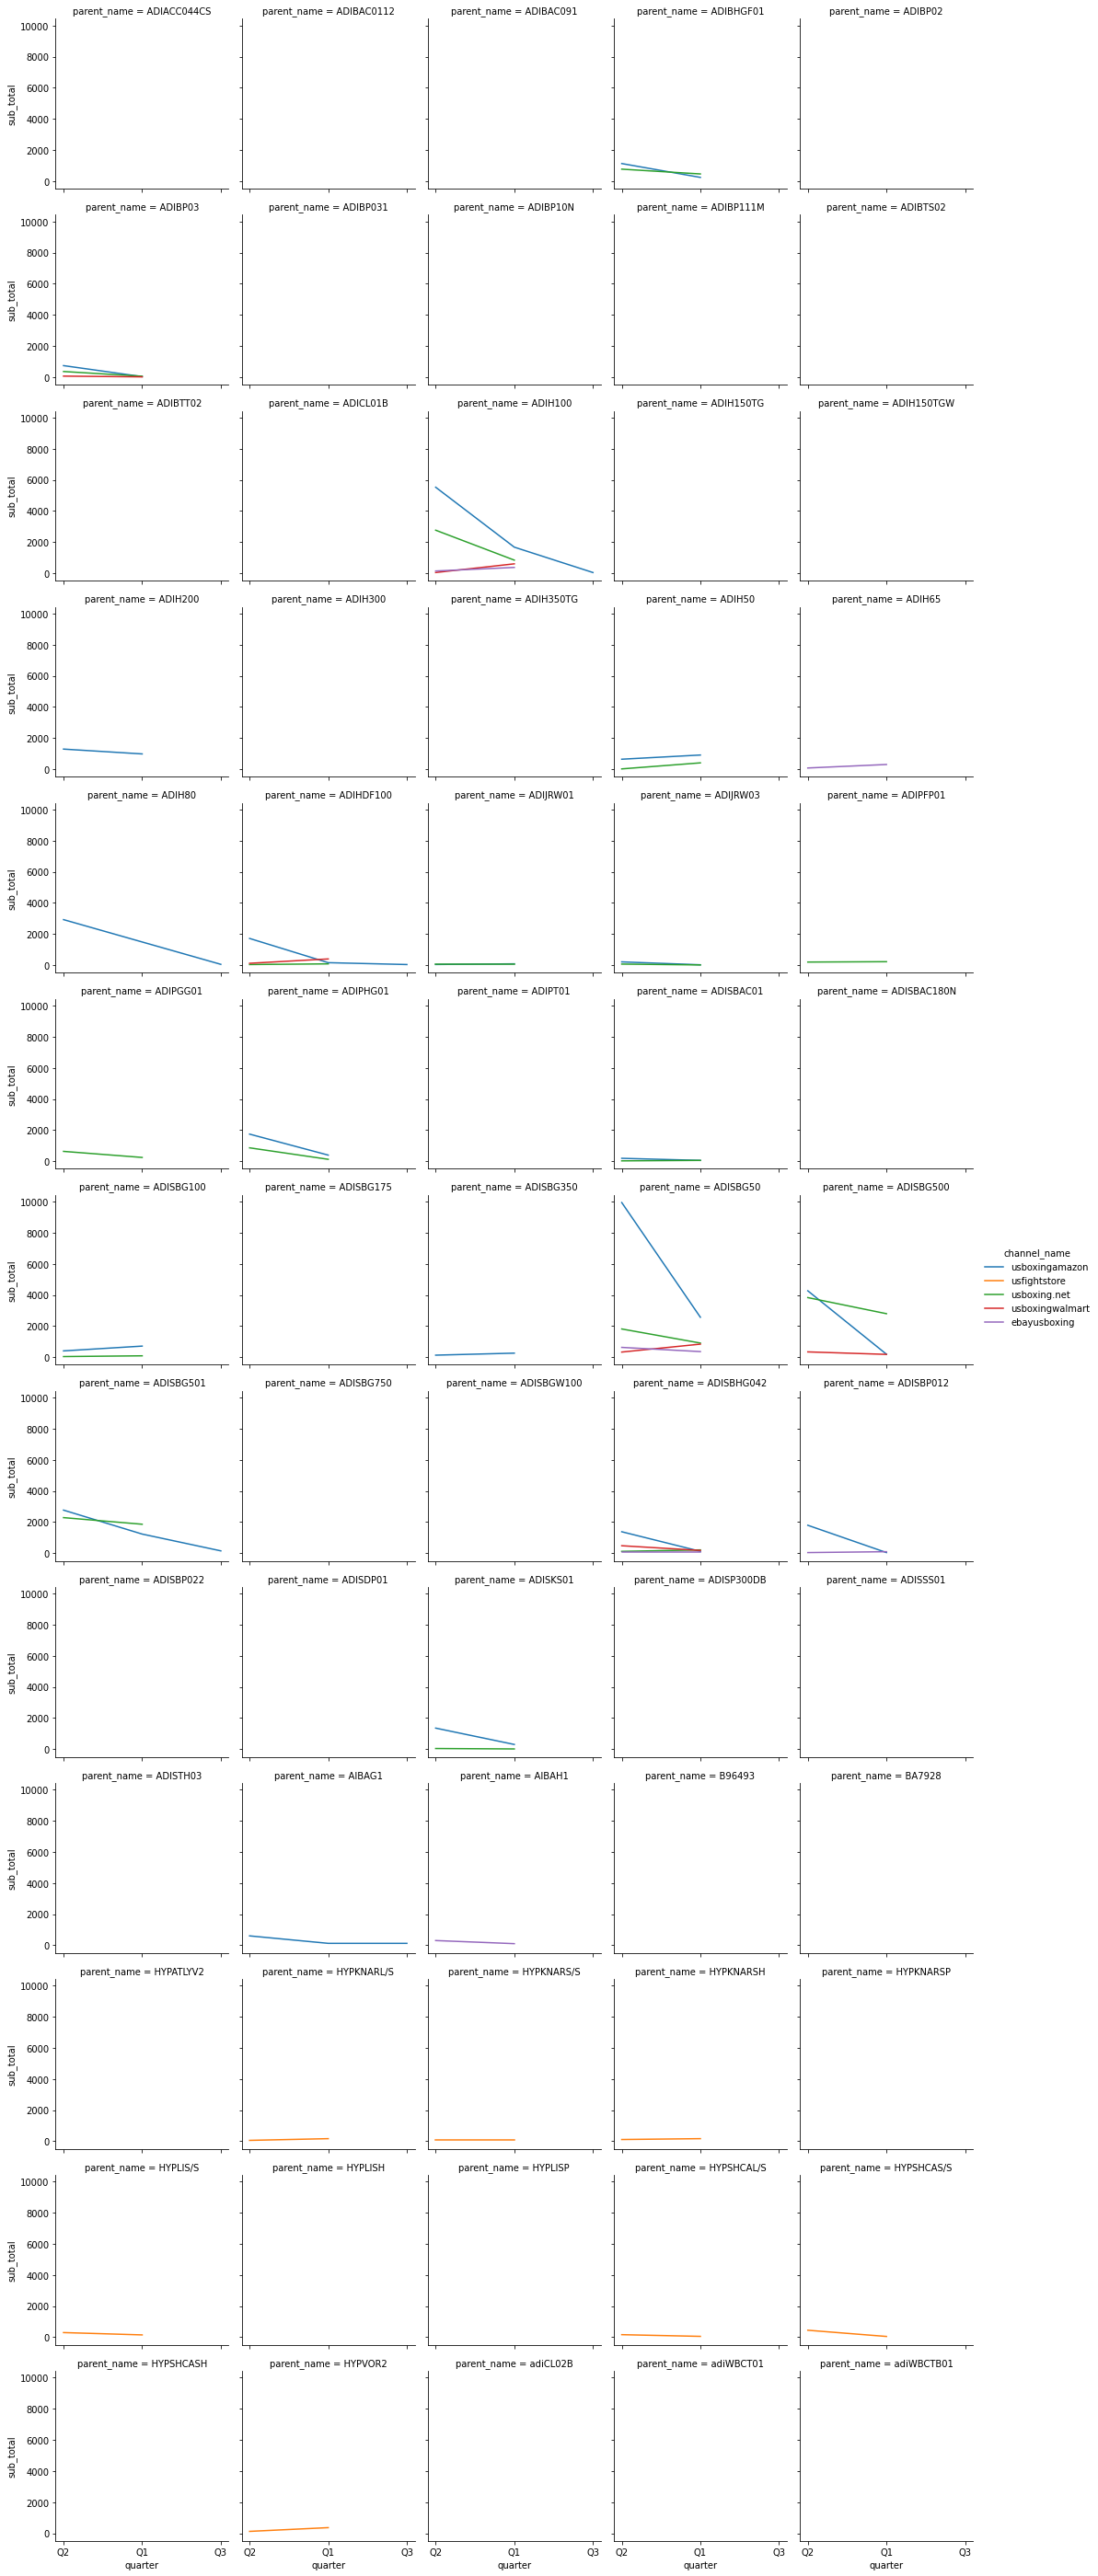

In [84]:
l=sns.FacetGrid(sales_21_quarterly, col='parent_name',hue='channel_name',col_wrap=5)
l=l.map(sns.lineplot,'quarter', 'sub_total').add_legend()

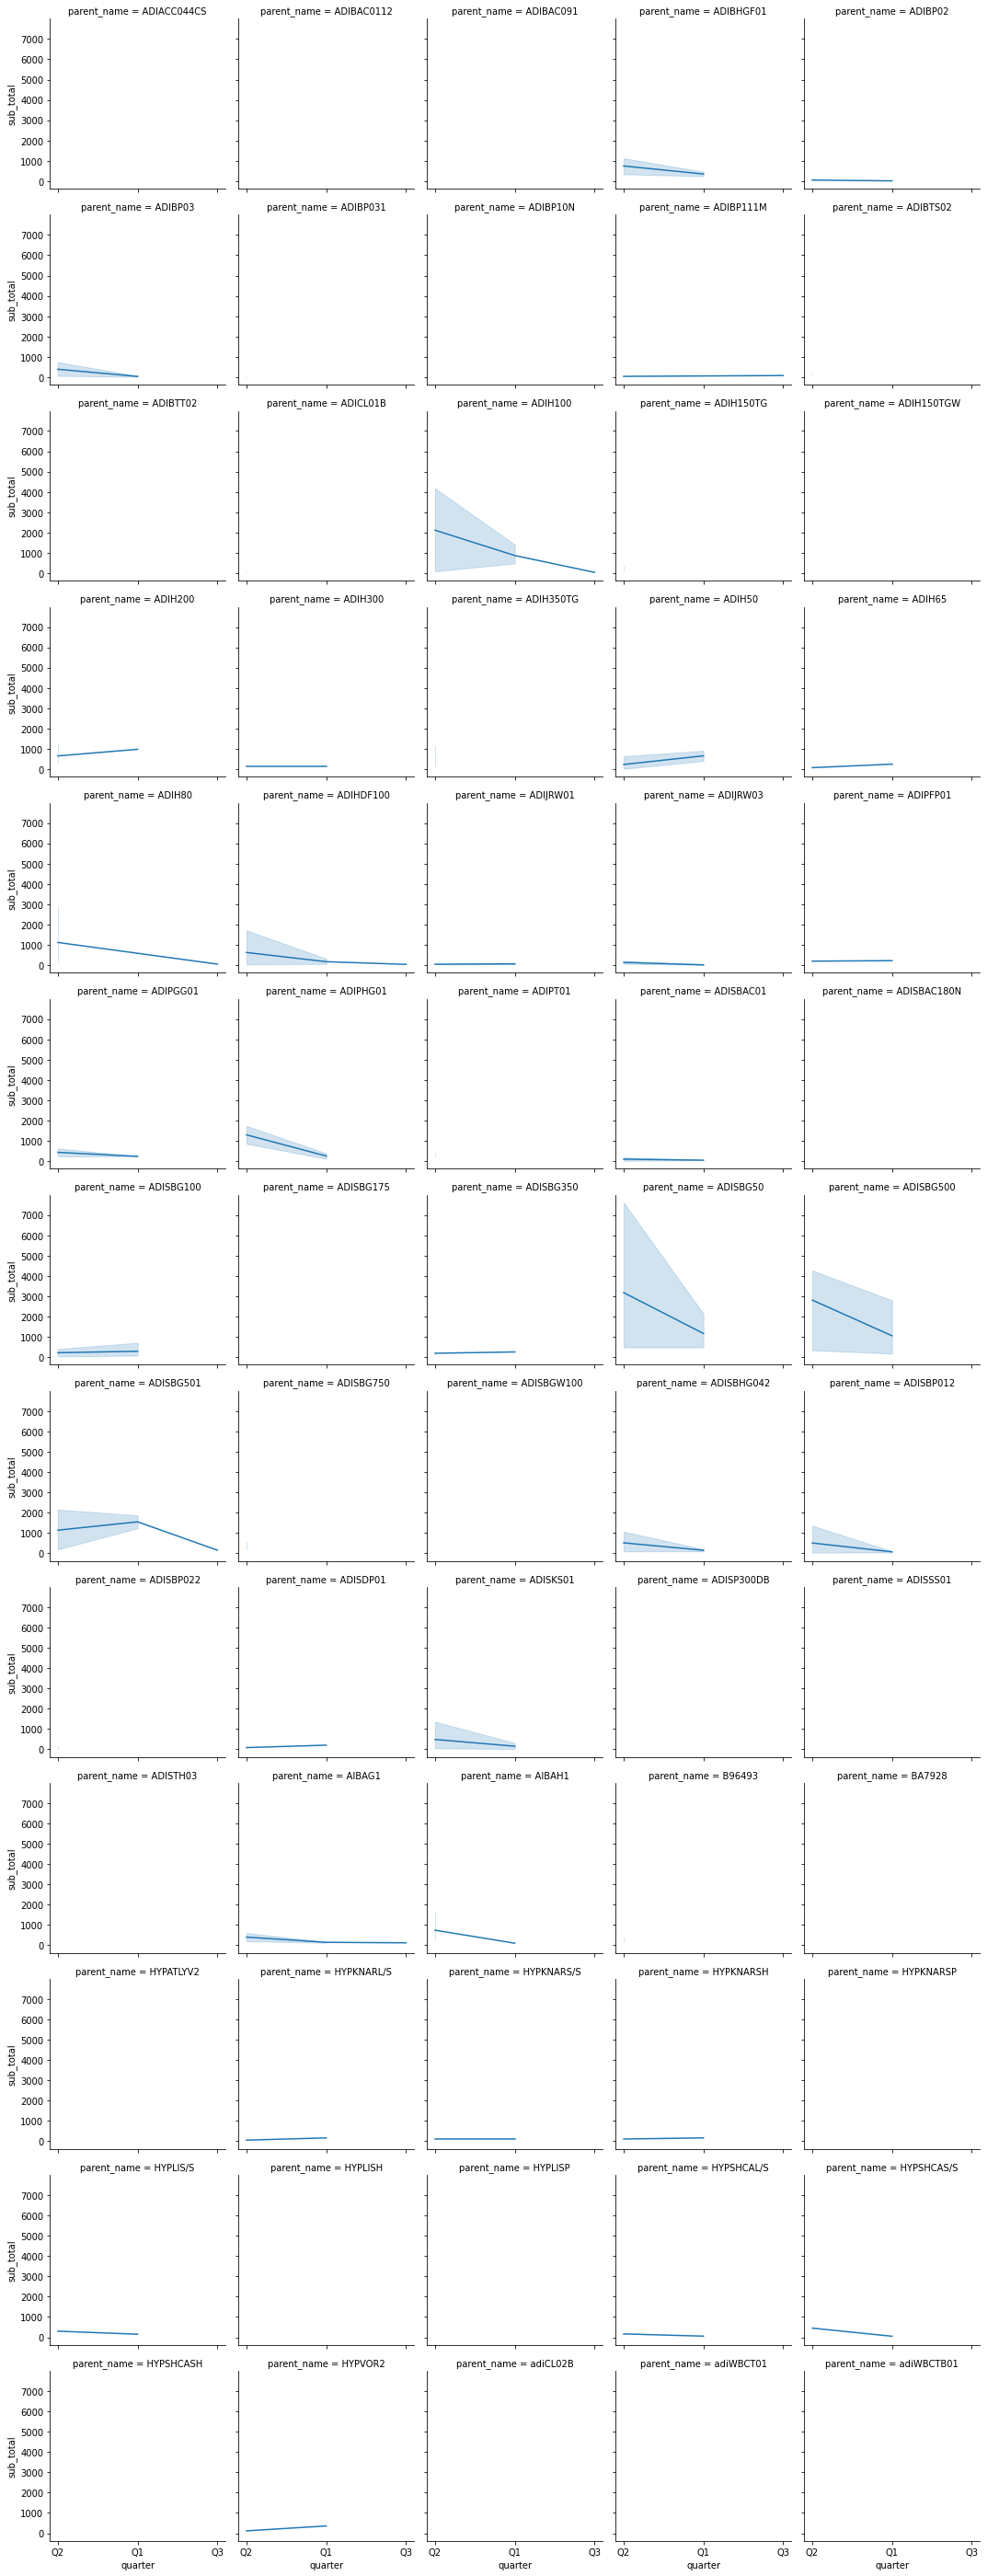

In [85]:
m=sns.FacetGrid(sales_21_quarterly, col='parent_name',col_wrap=5)
m=m.map(sns.lineplot,'quarter', 'sub_total').add_legend()

In [86]:
sales_21_quarterly.head(50)

,parent_name,quarter,channel_name,sub_total
0,ADIACC044CS,Q2,usboxingamazon,54.95
1,ADIBAC0112,Q2,usfightstore,229.88
2,ADIBAC091,Q2,usboxing.net,59.99
3,ADIBAC091,Q2,usboxingamazon,59.99
4,ADIBHGF01,Q1,usboxing.net,461.93
5,ADIBHGF01,Q1,usboxingamazon,239.98
6,ADIBHGF01,Q2,usboxing.net,769.65
7,ADIBHGF01,Q2,usboxingamazon,1129.90
8,ADIBHGF01,Q2,usboxingwalmart,339.97
9,ADIBP02,Q1,ebayusboxing,13.74


In [11]:
sales_21=twenty_one.groupby(['parent_name','sku'])['sub_total'].sum().sort_values(ascending=False)

In [13]:
sales_21=pd.DataFrame(sales_21)
sales_21

sub_total
parent_name sku                                           
ADISBG500   ADISBG500White/Blue metallic/Red16OZ   2749.17
ADIBHGF01   ADIBHGF01BlackS/M                      1819.64
ADISBG50    ADISBG50SYLDBL14oz                     1775.27
            ADISBG50SYLDBL12oz                     1771.77
ADISBG501   ADISBG501Black/Gold16OZ                1596.97
...                                                    ...
ADIBP031    ADIBP031Blue3,5M                         13.90
ADIBP03     ADIBP03Pink4,5M                          12.77
ADIBP02     ADIBP02Black/WhiteM                      11.95
ADIBP10N    ADIBP10NTransparentSenior                 7.99
ADIBP03     ADIBP03Pink2,55M                          5.95

[287 rows x 1 columns]

In [13]:
sales_21
ADISBG50	
ADIH100
ADISBG500
ADISBG501
ADIH80
...	

,sub_total
parent_name,
ADISBG50,17387.29
ADIH100,11977.65
ADISBG500,11606.45
ADISBG501,8917.11
ADIH80,3411.74
...,...
ADIBP031,69.50
ADIACC044CS,54.95
ADISSS01,49.95


In [90]:
sales_21.reset_index(inplace=True)

In [91]:
sales_21.head(30)

,parent_name,month,sub_total
0,ADIACC044CS,6,54.95
1,ADIBAC0112,6,229.88
2,ADIBAC091,4,59.99
3,ADIBAC091,6,59.99
4,ADIBHGF01,2,461.93
5,ADIBHGF01,3,239.98
6,ADIBHGF01,4,689.82
7,ADIBHGF01,5,339.97
8,ADIBHGF01,6,1209.73
9,ADIBP02,1,13.74


In [ ]:
sales_21_day=twenty_one.groupby(['parent_name','quarter'])['sub_total'].sum()

In [ ]:
sales_21_day=pd.DataFrame(sales_21_day)

In [ ]:
sales_21_day.head(40)